In [221]:
%config InlineBackend.figure_format = 'svg'

import pickle

import itertools
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import patsy

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge #ordinary linear regression + w/ ridge regularization
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [222]:
AUDIT_FEATURES = (
    'first_contentful_paint',
    'speed_index',
    'interactive',
    'first_meaningful_paint',
    'first_cpu_idle',
    'estimated_input_latency'
)

In [223]:
companies = pickle.load(open('combined.pkl', 'rb'))

In [224]:
companies.columns = [col_name.replace('-', '_') for col_name in companies.columns]

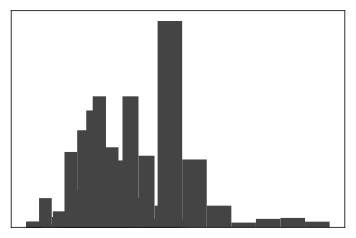

In [230]:
for i in range(len(AUDIT_FEATURES)):
    plt.hist(
        companies[AUDIT_FEATURES[i]],
        color='#444444'
    )

    # plt.xlabel('First CPU Idle')
    # plt.ylabel('Indeed Rating')
    plt.xticks([])
    plt.yticks([])

    plt.savefig(f'hist_{i}_log.png')

In [229]:
for feature in AUDIT_FEATURES:
    companies[feature] = np.log(companies[feature])

In [194]:
# sns.heatmap(companies.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

In [195]:
# find lowest vips

# combos = list(itertools.combinations(AUDIT_FEATURES, 3))
# d = {}

# for combo in combos:
#     print(combo)
#     X = companies[[*combo]]
#     vifs = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
#     # print([vif for vif in vifs if vif < 3])
#     acceptable = len([vif for vif in vifs if vif < 3])
#     d[combo] = acceptable

In [196]:
acceptable_vips_features = ['first_contentful_paint', 'first_meaningful_paint', 'estimated_input_latency']

In [197]:
# sns.pairplot(
#     companies,
#     kind='reg',
#     plot_kws={
#         'line_kws': {
#             'alpha': 0.5,
#             'color':'#f0a000'
#         },
#         'scatter_kws': {
#             'alpha': 0.1,
#             'edgecolors':'none',
#             'color': '#000000'
#         }
#     }
# );

In [198]:
model_features = acceptable_vips_features
X = companies[[*model_features]]
y = companies['indeed_rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=131)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.values)
X_test_scaled = scaler.transform(X_test.values);

In [199]:
patsy_X.columns

Index(['Intercept', 'first_contentful_paint', 'first_meaningful_paint',
       'estimated_input_latency'],
      dtype='object')

In [200]:
# statsmodel WITH terms:
d_matrix_train = X_train.copy()
d_matrix_train['indeed_rating'] = y_train
patsy_y, patsy_X = patsy.dmatrices(
    f'indeed_rating ~ {" + ".join(model_features)}',
    data=d_matrix_train,
    return_type='dataframe'
)

sm_intercepted_linear_model = sm.OLS(patsy_y, patsy_X)
sm_intercepted_linear_fit = sm_intercepted_linear_model.fit()
sm_intercepted_linear_fit.rsquared

0.009558712305021921

In [201]:
sm_intercepted_linear_fit.summary()
# all features:
  # R-squared: 			+0.015036757886496277
  # Adj. R-squared: 	-0.0068513141604704675
# acceptable vips:
  # R-squared: 			+0.009558712305021921
  # Adj. R-squared: 	-0.0013252578894282774



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          indeed_rating   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.8782
Date:                Thu, 24 Jan 2019   Prob (F-statistic):              0.453
Time:                        19:28:05   Log-Likelihood:                -2.0595
No. Observations:                 277   AIC:                             12.12
Df Residuals:                     273   BIC:                             26.62
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   3.8036      0.045     84.053      0.000       3.715       3.893
first_contentful_paint     -0.0334      0.039     -0.857      0.392      -0.110       0.043
first_meaningful_paint     -0.0071      0.044     -0.162      0.872      -0.094       0.080
estimated_input_latency     0.0140      0.015      0.942      0.347      -0.015       0.043
==============================================================================
Omnibus:                        9.882   Durbin-Watson:                   1.792
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               10.287
Skew:                          -0.391   Prob(JB):                      0.00584
Kurtosis:                       3.528   Cond. No.                         12.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [204]:
type(px)

matplotlib.collections.PathCollection

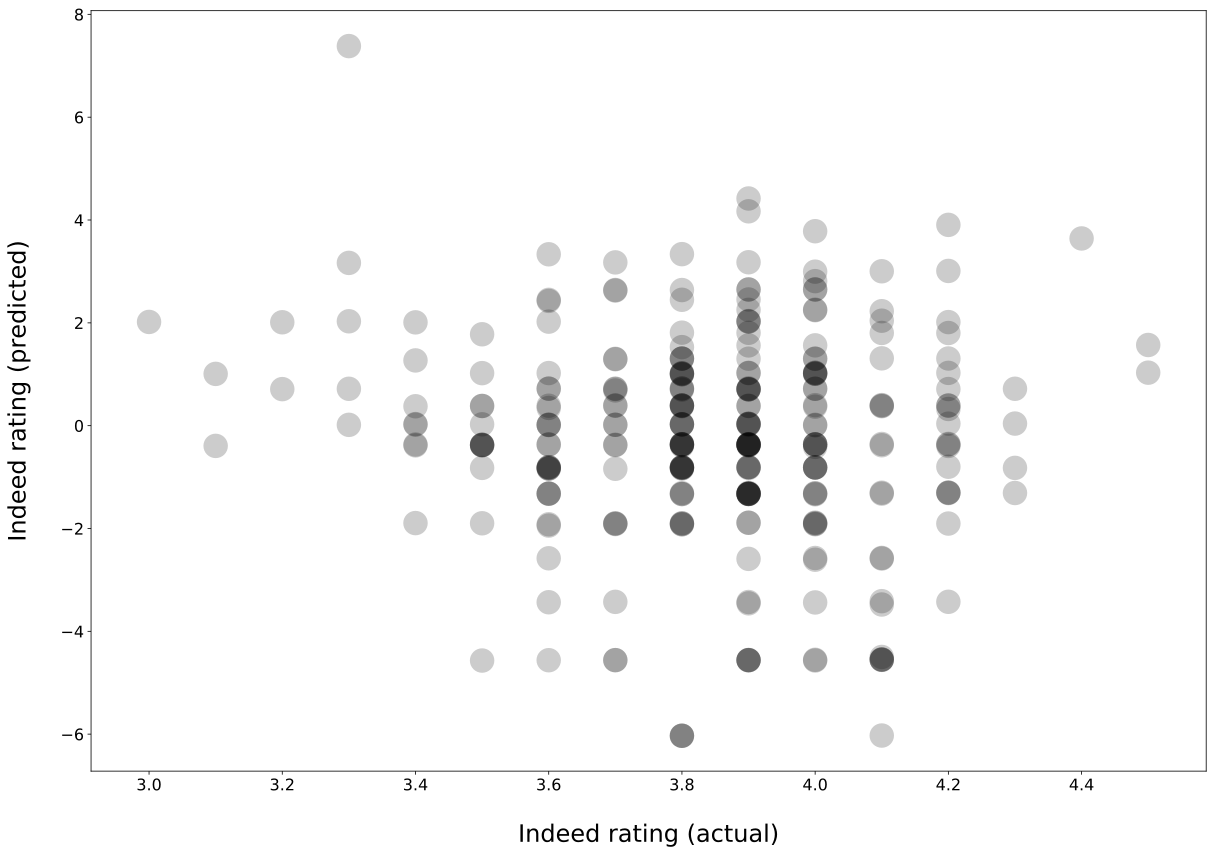

In [262]:
from matplotlib.pyplot import figure
# plt.savefig('bleg-foo')

plt.figure(figsize=(20, 14))
px = plt.scatter(
    y_train,
    sm_intercepted_linear_fit.predict(d_matrix_train),
    s=600,
    alpha=0.2,
    edgecolors='none',
    color='#000000'
)
# plt.axvline(x=0, color='#f08000', linestyle=':')
# plt.axvline(x=5, color='#f08000', linestyle=':')
# plt.axhline(y=0, color='#f08000', linestyle=':', linewidth=6)
# plt.axhline(y=5, color='#f08000', linestyle=':', linewidth=6)
plt.xlabel('Indeed rating (actual)', fontsize=24, labelpad=30)
plt.ylabel('Indeed rating (predicted)', fontsize=24, labelpad=30)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.savefig(f'predictions_no_line.png')

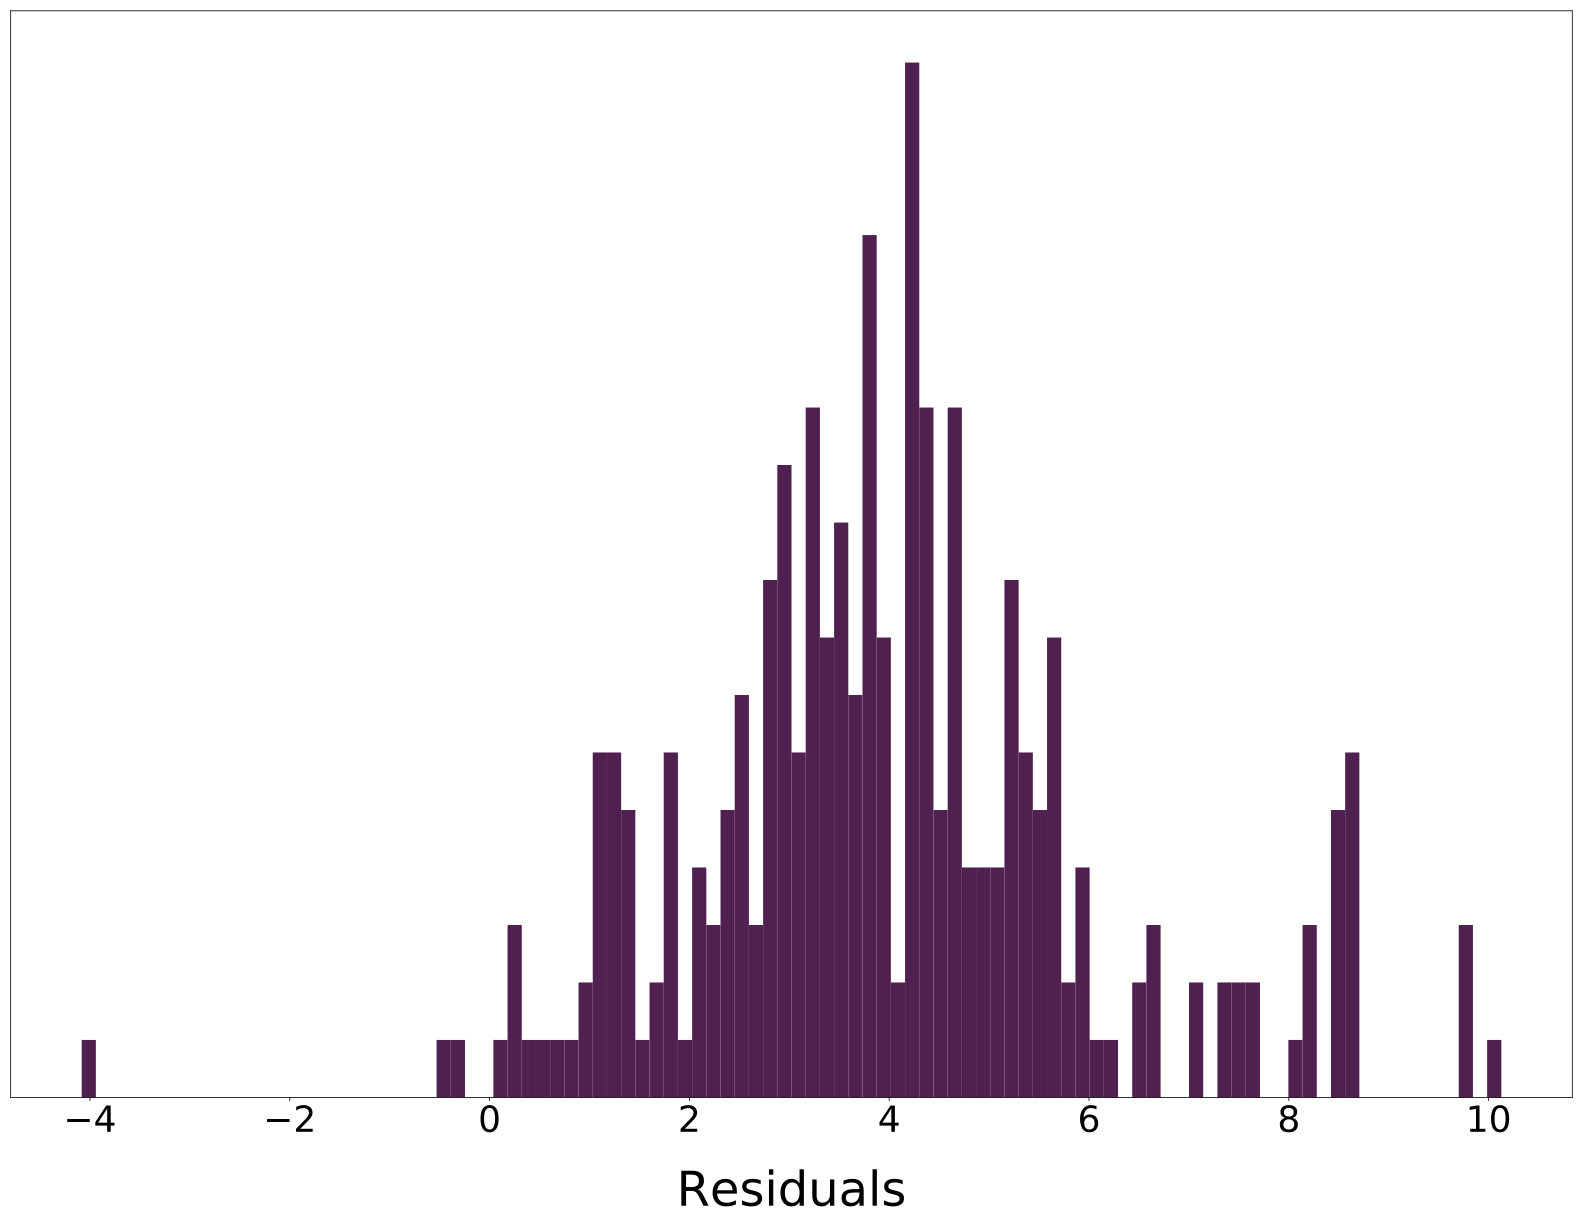

In [267]:
plt.figure(figsize=(28, 20))
plt.hist(
    y - sm_intercepted_linear_fit.predict(d_matrix_train),
    bins=100,
    color='#502050'
)
# plt.axvline(x=5, color='#f08000', linestyle=':', linewidth=10)
# plt.axvline(x=-5, color='#f08000', linestyle=':', linewidth=10)
plt.xlabel('Residuals', fontsize=48, labelpad=30)

plt.xticks(fontsize=36)
plt.yticks([])

plt.savefig(f'residuals_no_line.png')